In [1]:
import os
import tensorflow as tf
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

In [2]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"],
                                           cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

print('Number of devices: %d' % strategy.num_replicas_in_sync) 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [3]:
from keras.layers import Conv2D, BatchNormalization, Dense, ReLU, GlobalAveragePooling2D, Dropout, Activation
from keras import regularizers
from keras.models import Model, load_model
from keras import layers
from keras import Input
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, HTML
from keras.utils.image_utils import img_to_array, array_to_img, img_to_array, load_img
import pandas as pd

from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

In [4]:
## RAFDB
train_data_dir = r'W:/RAFDB/RAFDB/train/'
validation_data_dir = r'W:/RAFDB/RAFDB/val/'

# train_data_dir = r"C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/FER2013/FER2013 - names/train/"
# validation_data_dir = r"C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/FER2013/FER2013 - names/test/"

In [5]:
IMG_HEIGHT =224
IMG_WIDTH = 224
CHANNELS = 3

IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

num_classes = 7

batch_size=32*strategy.num_replicas_in_sync

csv_logger = CSVLogger('log.csv', separator=',', append=True)
class_labels=['Angry', 'Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [6]:
# Init the Image Data Generator
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Train Images
train_generator = train_data_gen.flow_from_directory(
        train_data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
)

# Validation images (From Train Images)
validation_generator = valid_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical'
)

Found 10733 images belonging to 7 classes.
Found 4606 images belonging to 7 classes.


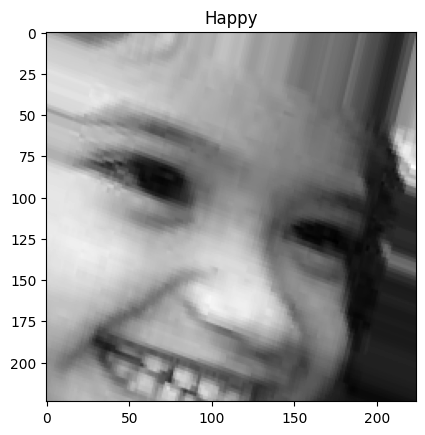

In [7]:
img, label = train_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

In [8]:
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_data_dir, 'train')
test_count = count_exp(validation_data_dir, 'test')

HTML(pd.concat([train_count, test_count], axis=0).to_html(escape=False))

,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
train,606,613,248,4169,2242,1722,1133
test,261,264,107,1788,962,738,486


In [9]:
num_train_imgs = 0
for root, dirs, files in os.walk(train_data_dir):
    num_train_imgs += len(files)
    
num_test_imgs = 0
for root, dirs, files in os.walk(validation_data_dir):
    num_test_imgs += len(files)

print(num_train_imgs)
print(num_test_imgs)

10733
4606


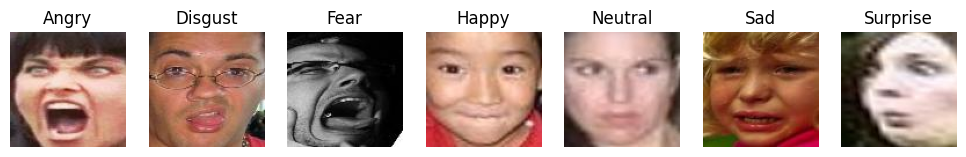

In [10]:
plt.figure(figsize=(14, 22))
i = 1
for expression in os.listdir(train_data_dir):
    img_file = random.choice(os.listdir(train_data_dir + expression))
    img = load_img(os.path.join(train_data_dir, expression, img_file))
    plt.subplot(1, 8, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [12]:
from collections import Counter

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : np.minimum(max_val/num_images,3) for class_id, num_images in counter.items()}     
print (class_weights)

# Callbacks

# Checkpoints
filepath="best_model.h5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    mode='max',
    save_freq='epoch')

#Early Stopping
Early = EarlyStopping(verbose=1, patience=20)

#Learning rate reduction
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10, verbose = 1,factor = 0.50, min_lr = 1e-10)

{0: 3.0, 1: 3.0, 2: 3.0, 3: 1.0, 4: 1.8595004460303302, 5: 2.421022067363531, 6: 3.0}


In [14]:
!pip install tabulate

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [19]:
from collections import Counter
from tabulate import tabulate

class_names = ['Angry', 'Disgust','Fear','Happy','Neutral','Sad','Surprise']  # Replace with your actual class names
class_id_to_name = {class_id: class_name for class_id, class_name in enumerate(class_names)}



counter = Counter(train_generator.classes)
max_val = float(max(counter.values()))
class_weights = {class_id_to_name[class_id]: np.minimum(max_val / num_images, 100) for class_id, num_images in counter.items()}
print(class_weights)

# Convert the dictionary to a list of lists for tabulate
table_data = [(class_name, weight) for class_name, weight in class_weights.items()]


# Print the table
print(tabulate(table_data, headers=["Class Name", "Class Weight"], tablefmt="grid"))

{'Angry': 6.87953795379538, 'Disgust': 6.800978792822186, 'Fear': 16.81048387096774, 'Happy': 1.0, 'Neutral': 1.8595004460303302, 'Sad': 2.421022067363531, 'Surprise': 3.679611650485437}
+--------------+----------------+
| Class Name   |   Class Weight |
+==============+================+
| Angry        |        6.87954 |
+--------------+----------------+
| Disgust      |        6.80098 |
+--------------+----------------+
| Fear         |       16.8105  |
+--------------+----------------+
| Happy        |        1       |
+--------------+----------------+
| Neutral      |        1.8595  |
+--------------+----------------+
| Sad          |        2.42102 |
+--------------+----------------+
| Surprise     |        3.67961 |
+--------------+----------------+


In [16]:
from collections import Counter
from tabulate import tabulate
import matplotlib.pyplot as plt
from PIL import Image

# Define your class names and class_id_to_name dictionary as mentioned earlier

counter = Counter(train_generator.classes)
max_val = float(max(counter.values()))
class_weights = {class_id_to_name[class_id]: np.minimum(max_val / num_images, 3) for class_id, num_images in counter.items()}

# Convert the dictionary to a list of lists for tabulate
table_data = [(class_name, weight) for class_name, weight in class_weights.items()]

# Create a tabulated table
table = tabulate(table_data, headers=["Class Name", "Class Weight"], tablefmt="grid")

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.axis('off')  # Turn off axis

# Display the table as text on the figure
ax.text(0, 0.95, table, va='top', fontfamily='monospace')

# Save the figure as an image
fig.savefig('class_weights_table.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.close()

# Optionally, open and display the saved image
image = Image.open('class_weights_table.png')
image.show()

In [12]:
class RepVGGBlock(layers.Layer):
      def __init__(self, out_channels, strides, kernel_size, name=None, **kwargs):
         super().__init__(name=name, **kwargs)
         self.out_channels = out_channels
         self.strides = strides
         self.kernel_size = kernel_size
         self.conv1 = Conv2D(out_channels, kernel_size, strides=strides, padding='same', use_bias=False)
         self.bn1 = BatchNormalization()
         self.relu = ReLU()
         self.conv2 = Conv2D(out_channels, kernel_size, padding='same', use_bias=False)
         self.bn2 = BatchNormalization()
         if strides == 1:
               self.identity_map = Activation('linear')
         else:
               self.identity_map = Conv2D(out_channels, kernel_size=1, strides=strides, padding='same', use_bias=False)
         
      def call(self, inputs):
         x = self.conv1(inputs)
         x = self.bn1(x)
         x = self.relu(x)
         x = self.conv2(x)
         x = self.bn2(x)
         identity_map = self.identity_map(inputs)
         return x + identity_map
      
      def get_config(self):
         config = super().get_config()
         config.update({
               'out_channels': self.out_channels,
               'strides': self.strides,
               'kernel_size': self.kernel_size,
         })
         return config

class GradientCheckpointing(layers.Layer):
      def __init__(self, checkpointing_depth, **kwargs):
         super().__init__(**kwargs)
         self.checkpointing_depth = checkpointing_depth

      def get_config(self):
         config = super().get_config()
         config.update({
               "checkpointing_depth": self.checkpointing_depth,
         })
         return config

      def call(self, inputs):
         if self.checkpointing_depth == 0:
               return inputs
         else:
               num_chunks = self.checkpointing_depth + 1
               chunk_size = inputs.shape[-1] // num_chunks
               remainder = inputs.shape[-1] % num_chunks
               if remainder != 0:
                  chunk_size += 1
               chunks = []
               for i in range(num_chunks):
                  start = i * chunk_size
                  end = start + chunk_size
                  if i == num_chunks - 1:
                     end = inputs.shape[-1]
                  chunk = inputs[..., start:end]
                  if i == 0:
                     chunk = tf.identity(chunk)
                  else:
                     chunk = tf.stop_gradient(chunk)
                  chunks.append(chunk)
         return tf.concat(chunks, axis=-1)

def create_repvgg_a0(checkpointing_depth=1):
      inputs = Input(shape=IMAGE_SHAPE)
      x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(inputs)
      x = BatchNormalization()(x)
      x = ReLU()(x)
      x = GradientCheckpointing(checkpointing_depth)(x)
      x = RepVGGBlock(out_channels=64, strides=1, kernel_size=3)(x)
      x = GradientCheckpointing(checkpointing_depth)(x)
      x = RepVGGBlock(out_channels=128, strides=2, kernel_size=3)(x)
      x = GradientCheckpointing(checkpointing_depth)(x)
      x = RepVGGBlock(out_channels=128, strides=1, kernel_size=3)(x)
      x = GradientCheckpointing(checkpointing_depth)(x)
      x = RepVGGBlock(out_channels=256, strides=2, kernel_size=3)(x)
      x = GradientCheckpointing(checkpointing_depth)(x)
      x = RepVGGBlock(out_channels=256, strides=1, kernel_size=3)(x)
      x = GradientCheckpointing(checkpointing_depth)(x)
      x = RepVGGBlock(out_channels=256, strides=1, kernel_size=3)(x)
      x = GradientCheckpointing(checkpointing_depth)(x)
      x = RepVGGBlock(out_channels=512, strides=2, kernel_size=3)(x)
      x = GradientCheckpointing(checkpointing_depth)(x)
      x = RepVGGBlock(out_channels=512, strides=1, kernel_size=3)(x)
      x = GradientCheckpointing(checkpointing_depth)(x)
      x = RepVGGBlock(out_channels=512, strides=1, kernel_size=3)(x)
      x = GradientCheckpointing(checkpointing_depth)(x)
      x = RepVGGBlock(out_channels=512, strides=1, kernel_size=3)(x)
      x = GradientCheckpointing(checkpointing_depth)(x)
      x = RepVGGBlock(out_channels=512, strides=1, kernel_size=3)(x)

      x = GlobalAveragePooling2D()(x)
      outputs = Dense(num_classes, activation='softmax')(x)  # number of classes in VGGFace2 dataset

      model = Model(inputs=inputs, outputs=outputs)

      return model

In [14]:
with strategy.scope():

    
   # model = create_repvgg_a0()

   custom_objects = {
    'RepVGGBlock': RepVGGBlock,
    'GradientCheckpointing': GradientCheckpointing
   }

   model = load_model("best_model.h5", custom_objects=custom_objects)


   model.compile(optimizer=Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])

   model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [15]:
# Train the model
history = model.fit(
                train_generator,
                steps_per_epoch = num_train_imgs//batch_size,
                epochs=300,
                validation_data=validation_generator,
                validation_steps = num_test_imgs//batch_size,
                class_weight=class_weights,
                callbacks=[checkpoint, Early, lrd, csv_logger],
                verbose=1)

Epoch 1/300
INFO:tensorflow:batch_all_reduce: 75 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 75 all-reduces with algorithm = hierarchical_copy, num_packs = 1
167/167 [==============================] - ETA: 0s - loss: 2.3735 - accuracy: 0.5831
Epoch 1: val_accuracy improved from -inf to 0.57152, saving model to best_model.h5
167/167 [==============================] - 140s 656ms/step - loss: 2.3735 - accuracy: 0.5831 - val_loss: 1.3716 - val_accuracy: 0.5715 - lr: 1.0000e-04
Epoch 2/300
167/167 [==============================] - ETA: 0s - loss: 2.2187 - accuracy: 0.6104
Epoch 2: val_accuracy did not improve from 0.57152
167/167 [==============================] - 118s 707ms/step - loss: 2.2187 - accuracy: 0.6104 - val_loss: 1.7212 - val_accuracy: 0.4487 - lr: 1.0000e-04
Epoch 3/300
167/167 [==============================] - ETA: 0s - loss: 2.0955 - accuracy: 0.6332
Epoch 3: val_accuracy improved from 0.57152 to 0.57857, saving model to b

In [16]:
save_model = model.save('REPVGG_106e2_rafdb_224_betterweights.h5')

In [30]:
custom_objects = {
    'RepVGGBlock': RepVGGBlock,
    'GradientCheckpointing': GradientCheckpointing
}

model = load_model("REPVGG_100e_FER.h5", custom_objects=custom_objects)

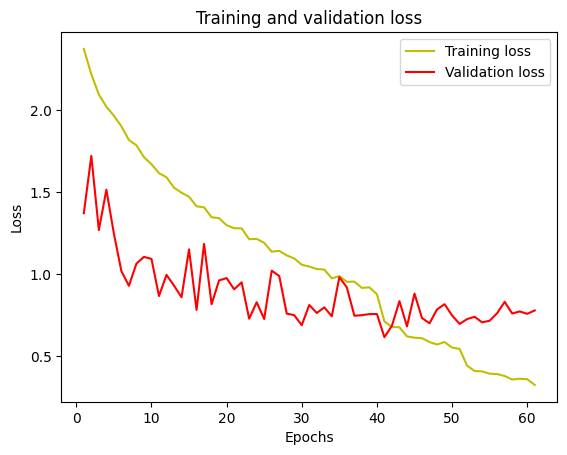

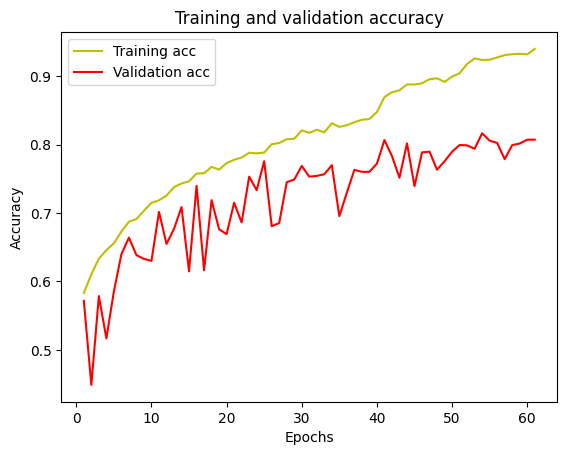

In [17]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 2s 68ms/step
Accuracy =  0.765625


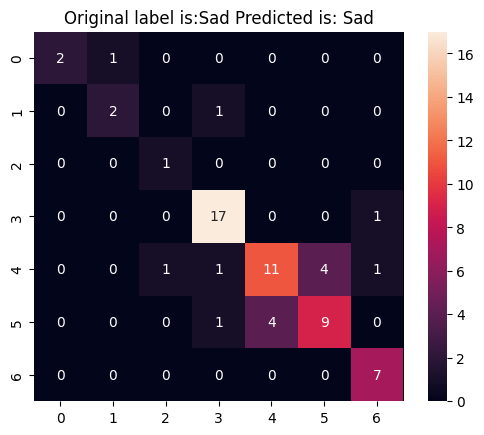

In [18]:
import random

#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
#print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Model Evaluation

Best batch saved
Worst batch saved
Worst batch saved
Best batch saved
Best batch saved
Best batch saved
Worst batch saved
Best batch saved
2/2 [==============================] - 0s 66ms/step
Accuracy =  0.90625


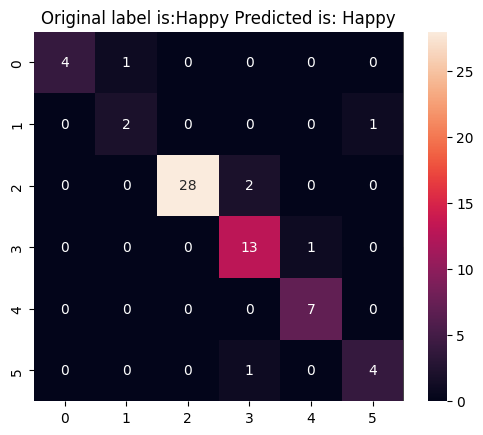

2/2 [==============================] - 0s 64ms/step
Accuracy =  0.65625


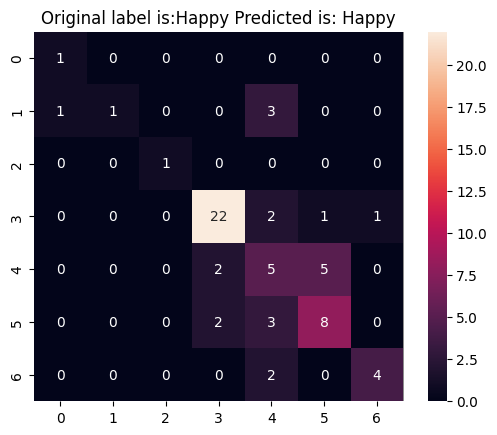

In [19]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [20]:
total_acc = 0
num_batches = validation_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = validation_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.8090


In [21]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 75ms/step
Accuracy: 80.89788732394366
Angry 258/4606 acc: 68.6
Disgust 260/4606 acc: 46.2
Fear 103/4606 acc: 57.3
Happy 1764/4606 acc: 90.5
Neutral 950/4606 acc: 76.6
Sad 731/4606 acc: 83.0
Surprise 478/4606 acc: 81.2


In [22]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


Accuracy: 80.89788732394366
Angry 258/4606 acc: 68.6
Disgust 260/4606 acc: 46.2
Fear 103/4606 acc: 57.3
Happy 1764/4606 acc: 90.5
Neutral 950/4606 acc: 76.6
Sad 731/4606 acc: 83.0
Surprise 478/4606 acc: 81.2


              precision    recall  f1-score   support

       Angry       0.77      0.69      0.73       258
     Disgust       0.60      0.46      0.52       260
        Fear       0.44      0.57      0.50       103
       Happy       0.93      0.91      0.92      1764
     Neutral       0.76      0.77      0.76       950
         Sad       0.73      0.83      0.78       731
    Surprise       0.84      0.81      0.83       478

    accuracy                           0.81      4544
   macro avg       0.72      0.72      0.72      4544
weighted avg       0.81      0.81      0.81      4544



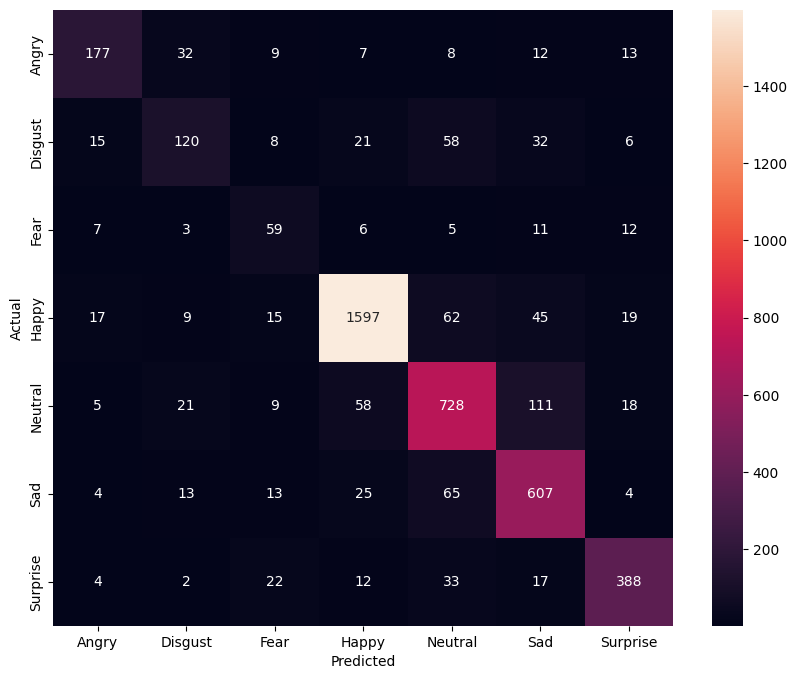

In [23]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Unseen batch

In [23]:
# custom_objects = {
#     'RepVGGBlock': RepVGGBlock,
#     'GradientCheckpointing': GradientCheckpointing
# }

# model = load_model('REPVGG_100e_FER.h5', custom_objects=custom_objects)

In [24]:
test_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7'

In [25]:
# Validation images (From Train Images)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 2100 images belonging to 7 classes.


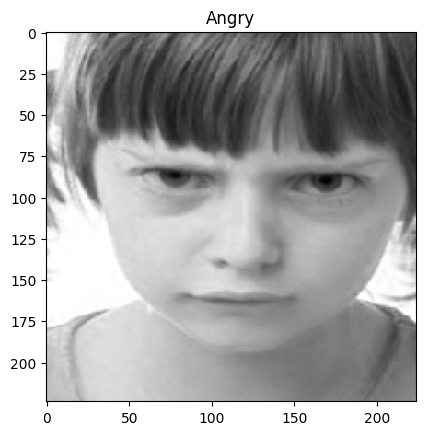

In [26]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

Best batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Best batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Best batch saved
Worst batch saved
Best batch saved
2/2 [==============================] - 0s 63ms/step
Accuracy =  0.6875


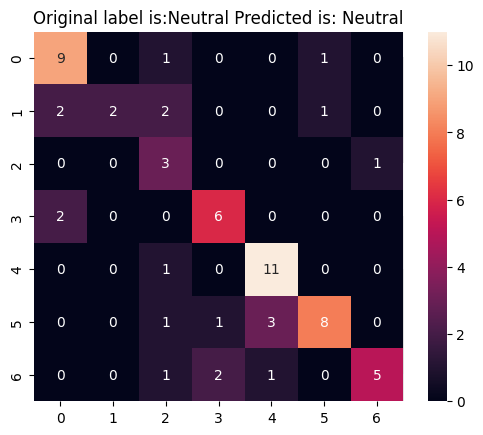

2/2 [==============================] - 0s 61ms/step
Accuracy =  0.4375


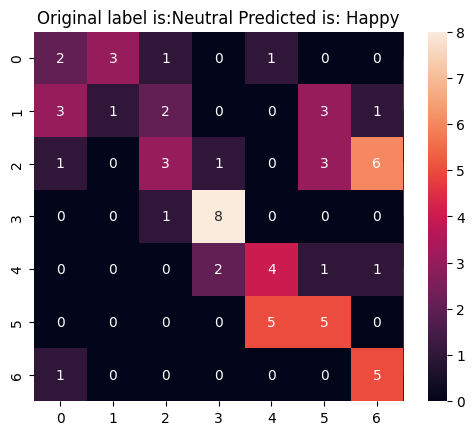

In [27]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [28]:
total_acc = 0
num_batches = test_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = test_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.5522


In [29]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 74ms/step
Accuracy: 55.224609375
Angry 293/2100 acc: 60.4
Disgust 296/2100 acc: 35.8
Fear 295/2100 acc: 33.6
Happy 293/2100 acc: 82.6
Neutral 293/2100 acc: 71.0
Sad 294/2100 acc: 43.9
Surprise 284/2100 acc: 59.9


# Accuracy global and per class

In [30]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

Accuracy: 55.224609375
Angry 293/2100 acc: 60.4
Disgust 296/2100 acc: 35.8
Fear 295/2100 acc: 33.6
Happy 293/2100 acc: 82.6
Neutral 293/2100 acc: 71.0
Sad 294/2100 acc: 43.9
Surprise 284/2100 acc: 59.9


              precision    recall  f1-score   support

       Angry       0.67      0.60      0.63       293
     Disgust       0.68      0.36      0.47       296
        Fear       0.53      0.34      0.41       295
       Happy       0.66      0.83      0.73       293
     Neutral       0.53      0.71      0.60       293
         Sad       0.36      0.44      0.40       294
    Surprise       0.53      0.60      0.56       284

    accuracy                           0.55      2048
   macro avg       0.56      0.55      0.54      2048
weighted avg       0.56      0.55      0.54      2048



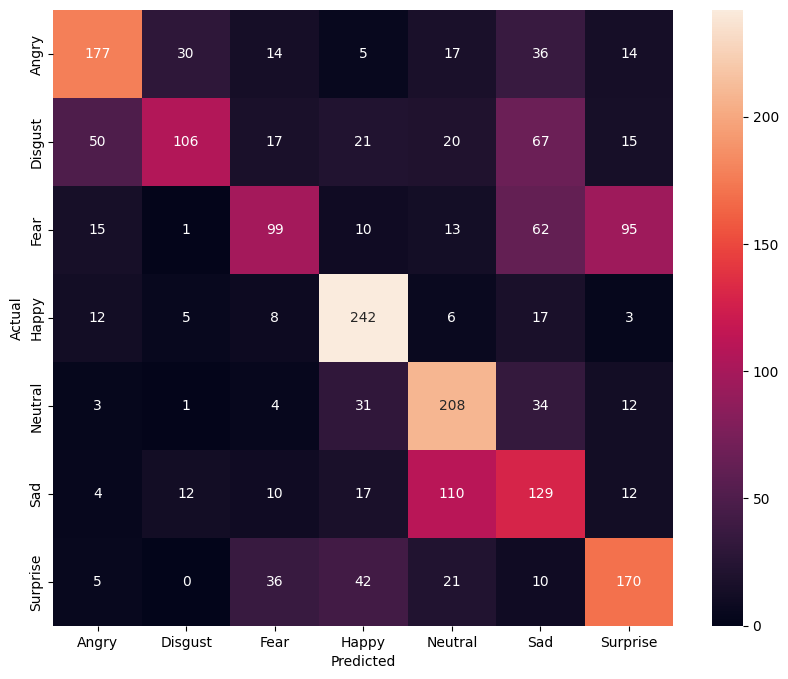

In [31]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test with Images

In [33]:
import cv2
import numpy as np
from keras.models import load_model

# # Load the pre-trained model
# model = load_model('Sequential_50e.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load the image and convert it to RGB format
image = cv2.imread("C:/Users/darks/Downloads/faces3.jpg")
# image = cv2.imread("C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7/Angry/anger-69.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces in the image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI
    face_image = rgb_image[y:y+h, x:x+w, :]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (224, 224))

    # Convert the resized image to a numpy array
    normalized_image = resized_image.astype('float32') / 255.0

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Draw a rectangle around the detected face
    cv2.rectangle(rgb_image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    cv2.putText(rgb_image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


# Convert the image from BGR to RGB format
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Resize the image to 450x450 pixels
rgb_image = cv2.resize(rgb_image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 0s 200ms/step
Predicted emotion class: neutral, probability: 0.717807948589325
1/1 [==============================] - 0s 195ms/step
Predicted emotion class: surprise, probability: 0.9999442100524902
1/1 [==============================] - 0s 188ms/step
Predicted emotion class: fear, probability: 0.5236051082611084
1/1 [==============================] - 0s 191ms/step
Predicted emotion class: neutral, probability: 0.6739777326583862
1/1 [==============================] - 0s 188ms/step
Predicted emotion class: happy, probability: 0.9999706745147705
1/1 [==============================] - 0s 194ms/step
Predicted emotion class: angry, probability: 0.9999258518218994
1/1 [==============================] - 0s 180ms/step
Predicted emotion class: angry, probability: 0.9897580146789551
1/1 [==============================] - 0s 187ms/step
Predicted emotion class: angry, probability: 0.9739581346511841
1/1 [==============================] - 0s 176ms/step
Predic

# Fine Tunning

In [33]:
# Compute the class weights
class_to_idx=validation_generator.class_indices
idx_to_class={class_to_idx[cls]:cls for cls in class_to_idx}
print(idx_to_class)

(unique, counts) = np.unique(train_generator.classes, return_counts=True)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(class_weights)

# Callbacks

# Checkpoints
filepath="checkpoints_freeze/toy-model_1-epoch-{epoch:02d}-val_accuracy-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=False, mode='auto', period=1)

#Early Stopping
Early = EarlyStopping(verbose=1, patience=20)

#Learning rate reduction
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 7, verbose = 1,factor = 0.50, min_lr = 1e-10)

{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
{0: 1.8060075093867334, 1: 16.54816513761468, 2: 1.7610446668293875, 3: 1.0, 4: 1.4531722054380665, 5: 1.4937888198757765, 6: 2.275307473982971}


In [34]:
with strategy.scope():

    custom_objects = {
    'RepVGGBlock': RepVGGBlock,
    'GradientCheckpointing': GradientCheckpointing
}

    model = load_model('checkpoints_freeze/toy-model_1-epoch-78-val_accuracy-0.63.h5', custom_objects=custom_objects)
    
    # # Load the VGG19 model
    # base_model = VGG16(
    #     weights='imagenet', 
    #     include_top=False, 
    #     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Freeze the layers
    # for layer in base_model.layers:
    #     layer.trainable = True
        
    # # # Unfreeze the last 5 layers
    # n = 5
    # for layer in base_model.layers[-n:]:
    #     layer.trainable = True

    # Create the new model on top
    # inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    # x = base_model(inputs)
    # x = Flatten()(x)
    # x = Dense(256, activation='relu')(x)
    # x = Dropout(0.2)(x)
    # x = Dense(128, activation='relu')(x) 
    # predictions = Dense(7, activation='softmax')(x)

    # # Compile the model
    # model = Model(inputs=inputs, outputs=predictions)


    model.compile(optimizer=Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 64)       256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 24, 24, 64)        0         
                                                                 
 gradient_checkpointing (Gra  (None, 24, 24, 64)       0         
 dientCheckpointing)                                             
                                                                 
 rep_vgg_block (RepVGGBlock)  (None, 24, 24, 64)       74240 

In [35]:
    # Train the model
history = model.fit(
                train_generator,
                steps_per_epoch = num_train_imgs//batch_size,
                epochs=300,
                validation_data=validation_generator,
                validation_steps = num_test_imgs//batch_size,
                class_weight=class_weights,
                callbacks=[checkpoint, Early, lrd, csv_logger],
                verbose=1)

Epoch 1/300
INFO:tensorflow:batch_all_reduce: 75 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 75 all-reduces with algorithm = hierarchical_copy, num_packs = 1
448/448 [==============================] - ETA: 0s - loss: 1.4396 - accuracy: 0.6659
Epoch 1: saving model to checkpoints_freeze\toy-model_1-epoch-01-val_accuracy-0.63.h5
448/448 [==============================] - 67s 106ms/step - loss: 1.4396 - accuracy: 0.6659 - val_loss: 1.0266 - val_accuracy: 0.6318 - lr: 1.0000e-05
Epoch 2/300
448/448 [==============================] - ETA: 0s - loss: 1.4192 - accuracy: 0.6714
Epoch 2: saving model to checkpoints_freeze\toy-model_1-epoch-02-val_accuracy-0.64.h5
448/448 [==============================] - 49s 109ms/step - loss: 1.4192 - accuracy: 0.6714 - val_loss: 1.0137 - val_accuracy: 0.6356 - lr: 1.0000e-05
Epoch 3/300
448/448 [==============================] - ETA: 0s - loss: 1.4242 - accuracy: 0.6684
Epoch 3: saving model to checkpoints_

In [52]:
save_model = model.save('REPVGG_FER2013_FINAL.h5')

# Fine Tunning model evaluation

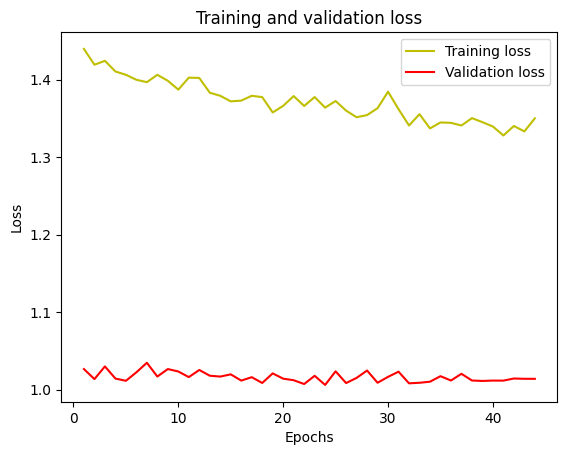

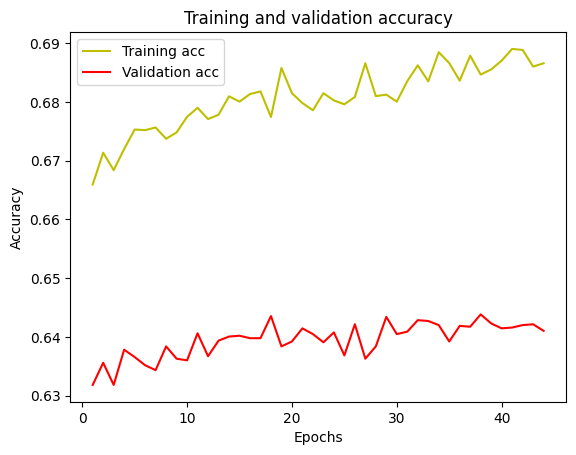

In [36]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 2s 15ms/step
Accuracy =  0.578125


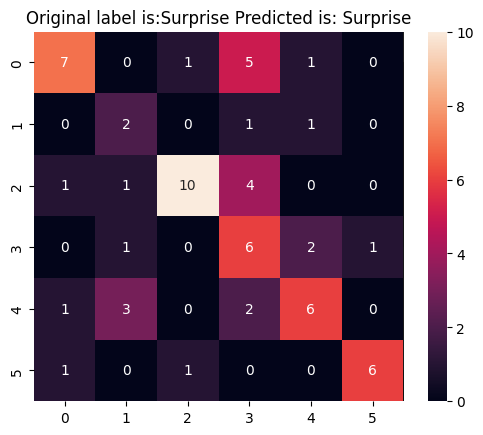

In [37]:
import random

#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
#print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

Best batch saved
Worst batch saved
Worst batch saved
Worst batch saved
Best batch saved
Best batch saved
Best batch saved
Worst batch saved
Best batch saved
Best batch saved
Best batch saved
Worst batch saved
2/2 [==============================] - 0s 44ms/step
Accuracy =  0.796875


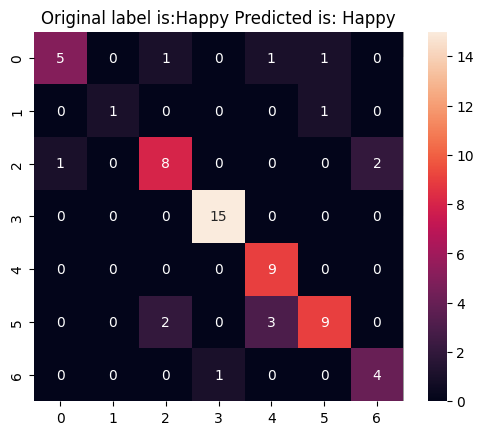

2/2 [==============================] - 0s 45ms/step
Accuracy =  0.5


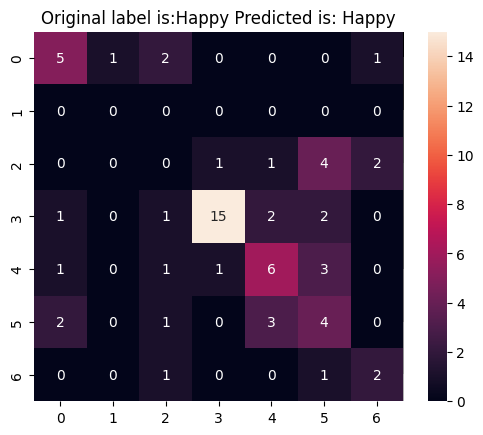

In [38]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [39]:
total_acc = 0
num_batches = validation_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = validation_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.6409


In [40]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(validation_generator.n // batch_size):
    test_img, test_lbl = validation_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 46ms/step
Accuracy: 64.09040178571429
Angry 956/7178 acc: 58.7
Disgust 111/7178 acc: 67.6
Fear 1023/7178 acc: 40.6
Happy 1772/7178 acc: 81.5
Neutral 1231/7178 acc: 66.7
Sad 1244/7178 acc: 49.3
Surprise 831/7178 acc: 80.0


In [41]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = validation_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{validation_generator.n} acc: {class_acc:.1f}")


Accuracy: 64.09040178571429
Angry 956/7178 acc: 58.7
Disgust 111/7178 acc: 67.6
Fear 1023/7178 acc: 40.6
Happy 1772/7178 acc: 81.5
Neutral 1231/7178 acc: 66.7
Sad 1244/7178 acc: 49.3
Surprise 831/7178 acc: 80.0


              precision    recall  f1-score   support

       Angry       0.53      0.59      0.56       956
     Disgust       0.58      0.68      0.62       111
        Fear       0.50      0.41      0.45      1023
       Happy       0.90      0.81      0.85      1772
     Neutral       0.56      0.67      0.61      1231
         Sad       0.53      0.49      0.51      1244
    Surprise       0.72      0.80      0.76       831

    accuracy                           0.64      7168
   macro avg       0.62      0.63      0.62      7168
weighted avg       0.64      0.64      0.64      7168



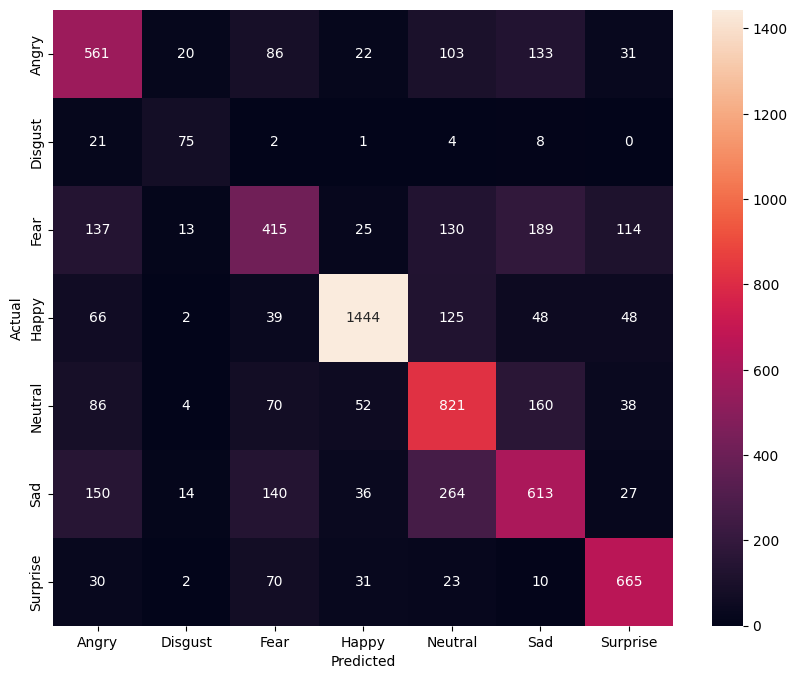

In [42]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Unseen batch

In [43]:
# model = load_model("VGG16_VGGFACE_100e_TF_FT_FER.h5")

In [44]:
test_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7'

In [45]:
# Validation images (From Train Images)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=(48, 48),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 2100 images belonging to 7 classes.


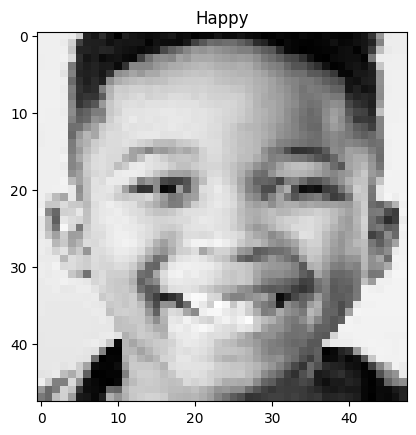

In [46]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

Best batch saved
Worst batch saved
Best batch saved
Best batch saved
Best batch saved
Best batch saved
Worst batch saved
Worst batch saved
2/2 [==============================] - 0s 45ms/step
Accuracy =  0.46875


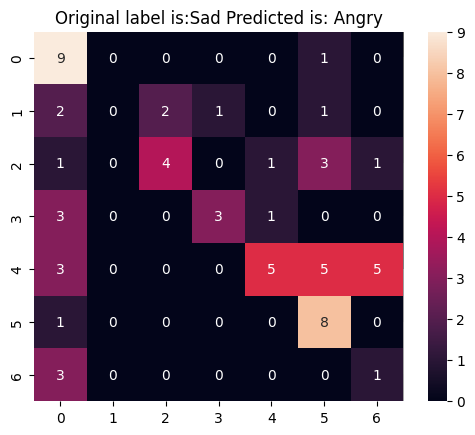

2/2 [==============================] - 0s 45ms/step
Accuracy =  0.1875


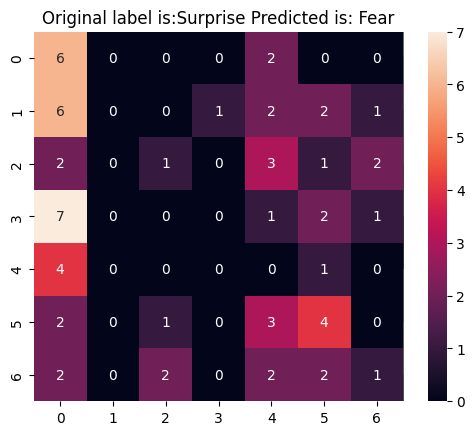

In [47]:
import pickle

# Save the best and worst batches
best_val_acc = 0
worst_val_acc = 1
for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    val_acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch = (test_img, test_lbl)
        with open('best_batch.pickle', 'wb') as f:
            pickle.dump(best_batch, f)
            print("Best batch saved")
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_batch = (test_img, test_lbl)
        with open('worst_batch.pickle', 'wb') as f:
            pickle.dump(worst_batch, f)
            print("Worst batch saved")

# Load the best batch
with open('best_batch.pickle', 'rb') as f:
    best_batch = pickle.load(f)
test_img, test_lbl = best_batch

# Generate predictions for the best batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the best batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

# Load the worst batch
with open('worst_batch.pickle', 'rb') as f:
    worst_batch = pickle.load(f)
test_img, test_lbl = worst_batch

# Generate predictions for the worst batch
predictions=model.predict(test_img)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

# Compute accuracy and confusion matrix for the worst batch
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [48]:
total_acc = 0
num_batches = test_generator.n // batch_size

for i in range(num_batches):
    test_img, test_lbl = test_generator.__getitem__(i)
    acc = model.evaluate(test_img, test_lbl, verbose=0)[1]
    total_acc += acc

avg_acc = total_acc / num_batches
print("Average accuracy: {:.4f}".format(avg_acc))

Average accuracy: 0.3022


In [49]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


2/2 [==============================] - 0s 64ms/step
Accuracy: 30.224609375
Angry 297/2100 acc: 72.4
Disgust 288/2100 acc: 2.1
Fear 292/2100 acc: 21.6
Happy 294/2100 acc: 31.0
Neutral 292/2100 acc: 16.4
Sad 291/2100 acc: 42.3
Surprise 294/2100 acc: 24.8


# Accuracy global and per class

In [50]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

Accuracy: 30.224609375
Angry 297/2100 acc: 72.4
Disgust 288/2100 acc: 2.1
Fear 292/2100 acc: 21.6
Happy 294/2100 acc: 31.0
Neutral 292/2100 acc: 16.4
Sad 291/2100 acc: 42.3
Surprise 294/2100 acc: 24.8


              precision    recall  f1-score   support

       Angry       0.25      0.72      0.37       297
     Disgust       0.67      0.02      0.04       288
        Fear       0.41      0.22      0.28       292
       Happy       0.59      0.31      0.41       294
     Neutral       0.21      0.16      0.18       292
         Sad       0.28      0.42      0.34       291
    Surprise       0.38      0.25      0.30       294

    accuracy                           0.30      2048
   macro avg       0.40      0.30      0.27      2048
weighted avg       0.40      0.30      0.27      2048



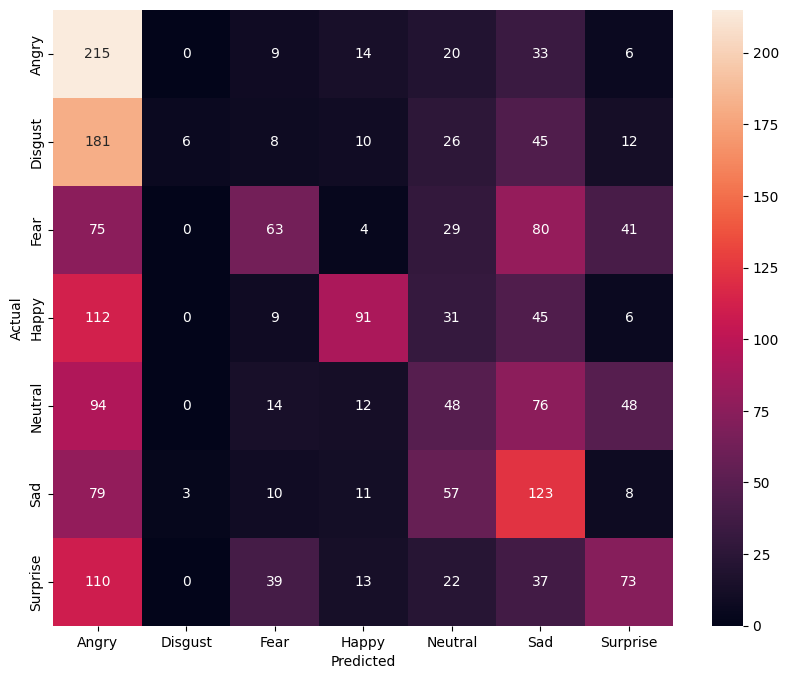

In [51]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test it with real images

In [53]:
import cv2
import numpy as np
from keras.models import load_model

# # Load the pre-trained model
# model = load_model('Sequential_50e.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load the image and convert it to RGB format
image = cv2.imread("C:/Users/darks/Downloads/faces3.jpg")
# image = cv2.imread("C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7/Angry/anger-69.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces in the image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI
    face_image = rgb_image[y:y+h, x:x+w, :]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (48, 48))

    # Convert the resized image to a numpy array
    normalized_image = resized_image.astype('float32') / 255.0

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Draw a rectangle around the detected face
    cv2.rectangle(rgb_image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    cv2.putText(rgb_image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


# Convert the image from BGR to RGB format
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Resize the image to 450x450 pixels
rgb_image = cv2.resize(rgb_image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", rgb_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 0s 28ms/step
Predicted emotion class: neutral, probability: 0.46993914246559143
1/1 [==============================] - 0s 25ms/step
Predicted emotion class: surprise, probability: 0.9699739217758179
1/1 [==============================] - 0s 30ms/step
Predicted emotion class: angry, probability: 0.5640920400619507
1/1 [==============================] - 0s 26ms/step
Predicted emotion class: neutral, probability: 0.6709685921669006
1/1 [==============================] - 0s 23ms/step
Predicted emotion class: happy, probability: 0.4932018518447876
1/1 [==============================] - 0s 27ms/step
Predicted emotion class: angry, probability: 0.9910394549369812
1/1 [==============================] - 0s 27ms/step
Predicted emotion class: neutral, probability: 0.6006370186805725
1/1 [==============================] - 0s 25ms/step
Predicted emotion class: sad, probability: 0.6517034769058228
1/1 [==============================] - 0s 24ms/step
Predicted em

# Testing model with webcam

In [55]:
import cv2
import numpy as np
from keras.models import load_model

# Load the pre-trained model
# model = load_model('Sequential_50e.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Initialize the video capture object
cap = cv2.VideoCapture(0)

# Loop through each video frame
while True:
    # Read a video frame
    ret, frame = cap.read()
    
    # Convert the frame from BGR to RGB format
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Detect faces in the frame
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray_frame, 1.3, 5)

    # Loop through each detected face
    for (x, y, w, h) in faces:
        # Extract the face ROI
        face_image = rgb_frame[y:y+h, x:x+w, :]

        # Resize the face ROI to 48x48 pixels
        resized_image = cv2.resize(face_image, (48, 48))

        # Convert the resized image to a numpy array
        normalized_image = resized_image.astype('float32') / 255.0

        # Make a prediction on the normalized image using the loaded model
        predictions = model.predict(np.expand_dims(normalized_image, axis=0))

        # Get the index of the highest predicted class
        predicted_class_index = np.argmax(predictions)

        # Print the predicted emotion class and its corresponding probability
        predicted_class = emotion_classes[predicted_class_index]
        predicted_probability = predictions[0][predicted_class_index]
        print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

        # Draw a rectangle around the detected face
        cv2.rectangle(rgb_frame, (x, y), (x+w, y+h), (0, 255, 0), 1)

        # Display the predicted emotion class and its corresponding probability on the frame
        text = f"{predicted_class} ({predicted_probability:.2f})"
        cv2.putText(rgb_frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Convert the frame from RGB to BGR format
    bgr_frame = cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2BGR)

    # Display the frame with the detected faces and their predictions
    cv2.imshow("Video", bgr_frame)

    # Wait for a key press and check if the 'q' key was pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 25ms/step
Predicted emotion class: neutral, probability: 0.614880383014679
1/1 [==============================] - 0s 27ms/step
Predicted emotion class: surprise, probability: 0.45024436712265015
1/1 [==============================] - 0s 26ms/step
Predicted emotion class: neutral, probability: 0.6629235148429871
1/1 [==============================] - 0s 27ms/step
Predicted emotion class: neutral, probability: 0.7383639812469482
1/1 [==============================] - 0s 25ms/step
Predicted emotion class: surprise, probability: 0.8927065134048462
1/1 [==============================] - 0s 24ms/step
Predicted emotion class: happy, probability: 0.4720451235771179
1/1 [==============================] - 0s 25ms/step
Predicted emotion class: sad, probability: 0.2925080358982086
1/1 [==============================] - 0s 23ms/step
Predicted emotion class: neutral, probability: 0.7815211415290833
1/1 [==============================] - 0s 24ms/step
Predicte